<h1><center>Gotta Generate ‘Em All</center></h1>
<h3><center> A pokemon generator project using DCGAN </center></h3>
<h4><center>    By Will, Kiet, and Josh <center></h4>

---

# STEP 1: PREP WORK & VISUALIZATION FOR GAN

RUN TOP CELL IF USING COLAB

In [1]:
#!git clone https://github.com/pwilly1000/PokemonGenerator.git

RUN THIS CELL IF RUNNING LOCALY

In [1]:
import os
image_folder = os.path.join("..", "PokemonGenerator", "png_dataset")

In [ ]:
ATTEMPT_NUMBER = "4" # Keeps track of what generation we are running

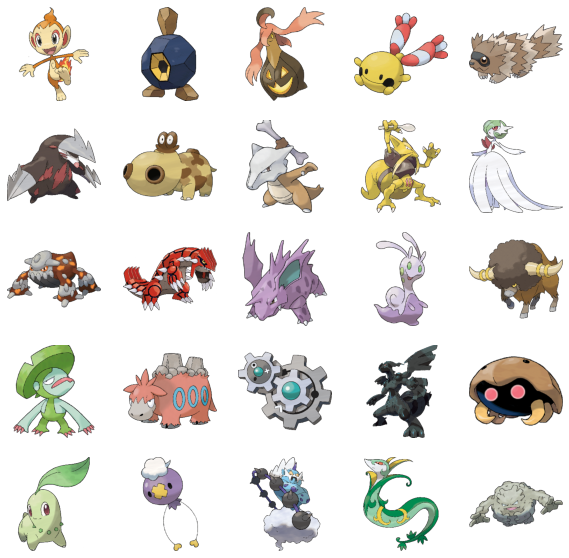

In [2]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Load image paths
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Randomly sample image paths
sample_size = 25
sample_paths = random.sample(image_paths, sample_size)

# Load and display images in a grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i, path in enumerate(sample_paths):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

#First check is done, as we have started by visualizing the data to check the quality of the images

# STEP 2: DATA AUGMENTATION 

2023-04-29 01:23:11.440988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


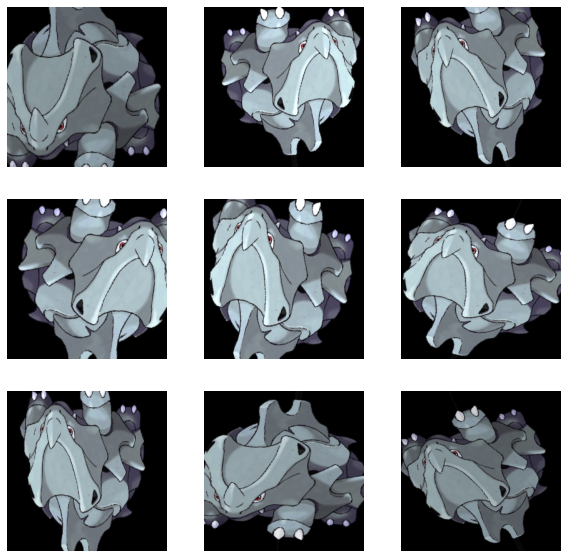

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random

# Define the data augmentation pipeline using ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2]
)

# Load a sample image to try and preprocess it
val = random.randint(1, 721)
#file = os.path.join(image_folder, str(val) +".png")
file = os.path.join(image_folder, random.choice(os.listdir(image_folder)))
image = load_img(file)  # Load image
image = img_to_array(image)   # Convert to NumPy array
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Apply data augmentation to the sample image
augmented_images = []
batch_size = 9

for batch in datagen.flow(image, batch_size=batch_size):
    augmented_images.append(batch[0])
    if len(augmented_images) >= batch_size:
        break

# Visualize the augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, img in enumerate(augmented_images):
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

>
>**This seems to be working pretty well. When integrating this pipeline into our training process, we can replace the sample image with our entire dataset, and feed the augmented images to the GAN during training!!**
>> To do this we just need to call *datagen.flow()* on our dataset when feeding images to the GAN during training.

# STEP 3: PREPROCESS THE DATA FOR MODEL

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import warnings

2023-05-02 10:39:28.573838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#image_folder = "../PokemonGenerator/png_dataset"
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
# Creating a list of image file paths by combining the image_folder path with the filenames of all images in the folder
# By creating a list of file paths, we can easily iterate over them and load each image in the load_image() function, which processes and prepares the images for training the GAN model

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3) # Decode PNG-encoded image data and PNG images usually have 3 color channels
    image = tf.image.resize(image, (64, 64)) # resize
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0 # Normalizing pixel values to the range of [-1, 1]
    return image

# Create a TensorFlow dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the load_image function to each image in the dataset to preprocess them
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) 

# Shuffle the dataset and batch the images for training the GAN
dataset = dataset.shuffle(buffer_size=1000).batch(1).prefetch(tf.data.AUTOTUNE)

# AUTOTUNE is a parameter in TensorFlow's tf.data API, 
# it allows TensorFlow to automatically determine the optimal number of parallel calls to use for data preprocessing operations
# https://www.tensorflow.org/guide/data_performance

2023-05-02 10:39:34.112913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


> **Using this tutorial: https://www.tensorflow.org/tutorials/generative/dcgan**
> **We ended up slightly tweaking their design and adding another layer**

# STEP 4: DEFINING THE GENERATOR & DISCRIMINATOR MODEL

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)
   # Ensuring that the output shape of the model is as expected after each layer is added (debug purposes)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Additional Convolutional Layers
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Adding an additional convolutional layer with 1024 filters
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# STEP 5: CREATING GENERATOR, DISCRIMINATOR AND DEFINING THE LOSS FUNCTIONS AND OPTIMIZERS

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# STEP 6: DEFINING THE TRAINING STEP FUNCTION

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        generated_images = tf.image.resize(generated_images, [64, 64])

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# STEP 7: DEFINING THE TRAINING LOOP

In [11]:
import time
import imageio

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the generated images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1)
            print(f"Saved Image for epoch {epoch + 1}")

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

# STEP 8: DEFINING THE FUNCTION TO GENERATE AND SAVE IMAGES

In [12]:
import matplotlib.pyplot as plt
import os

if not os.path.exists("generated_images" + ATTEMPT_NUMBER):
    os.makedirs("generated_images" + ATTEMPT_NUMBER)


def generate_and_save_images(model, epoch):
    noise = tf.random.normal([16, 100])
    generated_images = model(noise, training=False)

    generated_images = tf.image.resize(generated_images, [64, 64])
    
    fig = plt.figure(figsize=(8, 8))

    for i in range(generated_images.shape[0]):
        # Resize the generated images to (64, 64)
        image = tf.image.resize(generated_images[i], (64, 64))
        # Scale the pixel values from [-1, 1] to [0, 1]
        image = (image + 1) / 2
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.savefig(os.path.join("generated_images" + ATTEMPT_NUMBER, f'image_at_epoch_{epoch:04d}.png'))
    plt.close()

# STEP 9: Training the DCGAN

In [ ]:
EPOCHS = 310

train(dataset, EPOCHS)

# In future, save a gif of all epochs ran

# DCGAN Visual

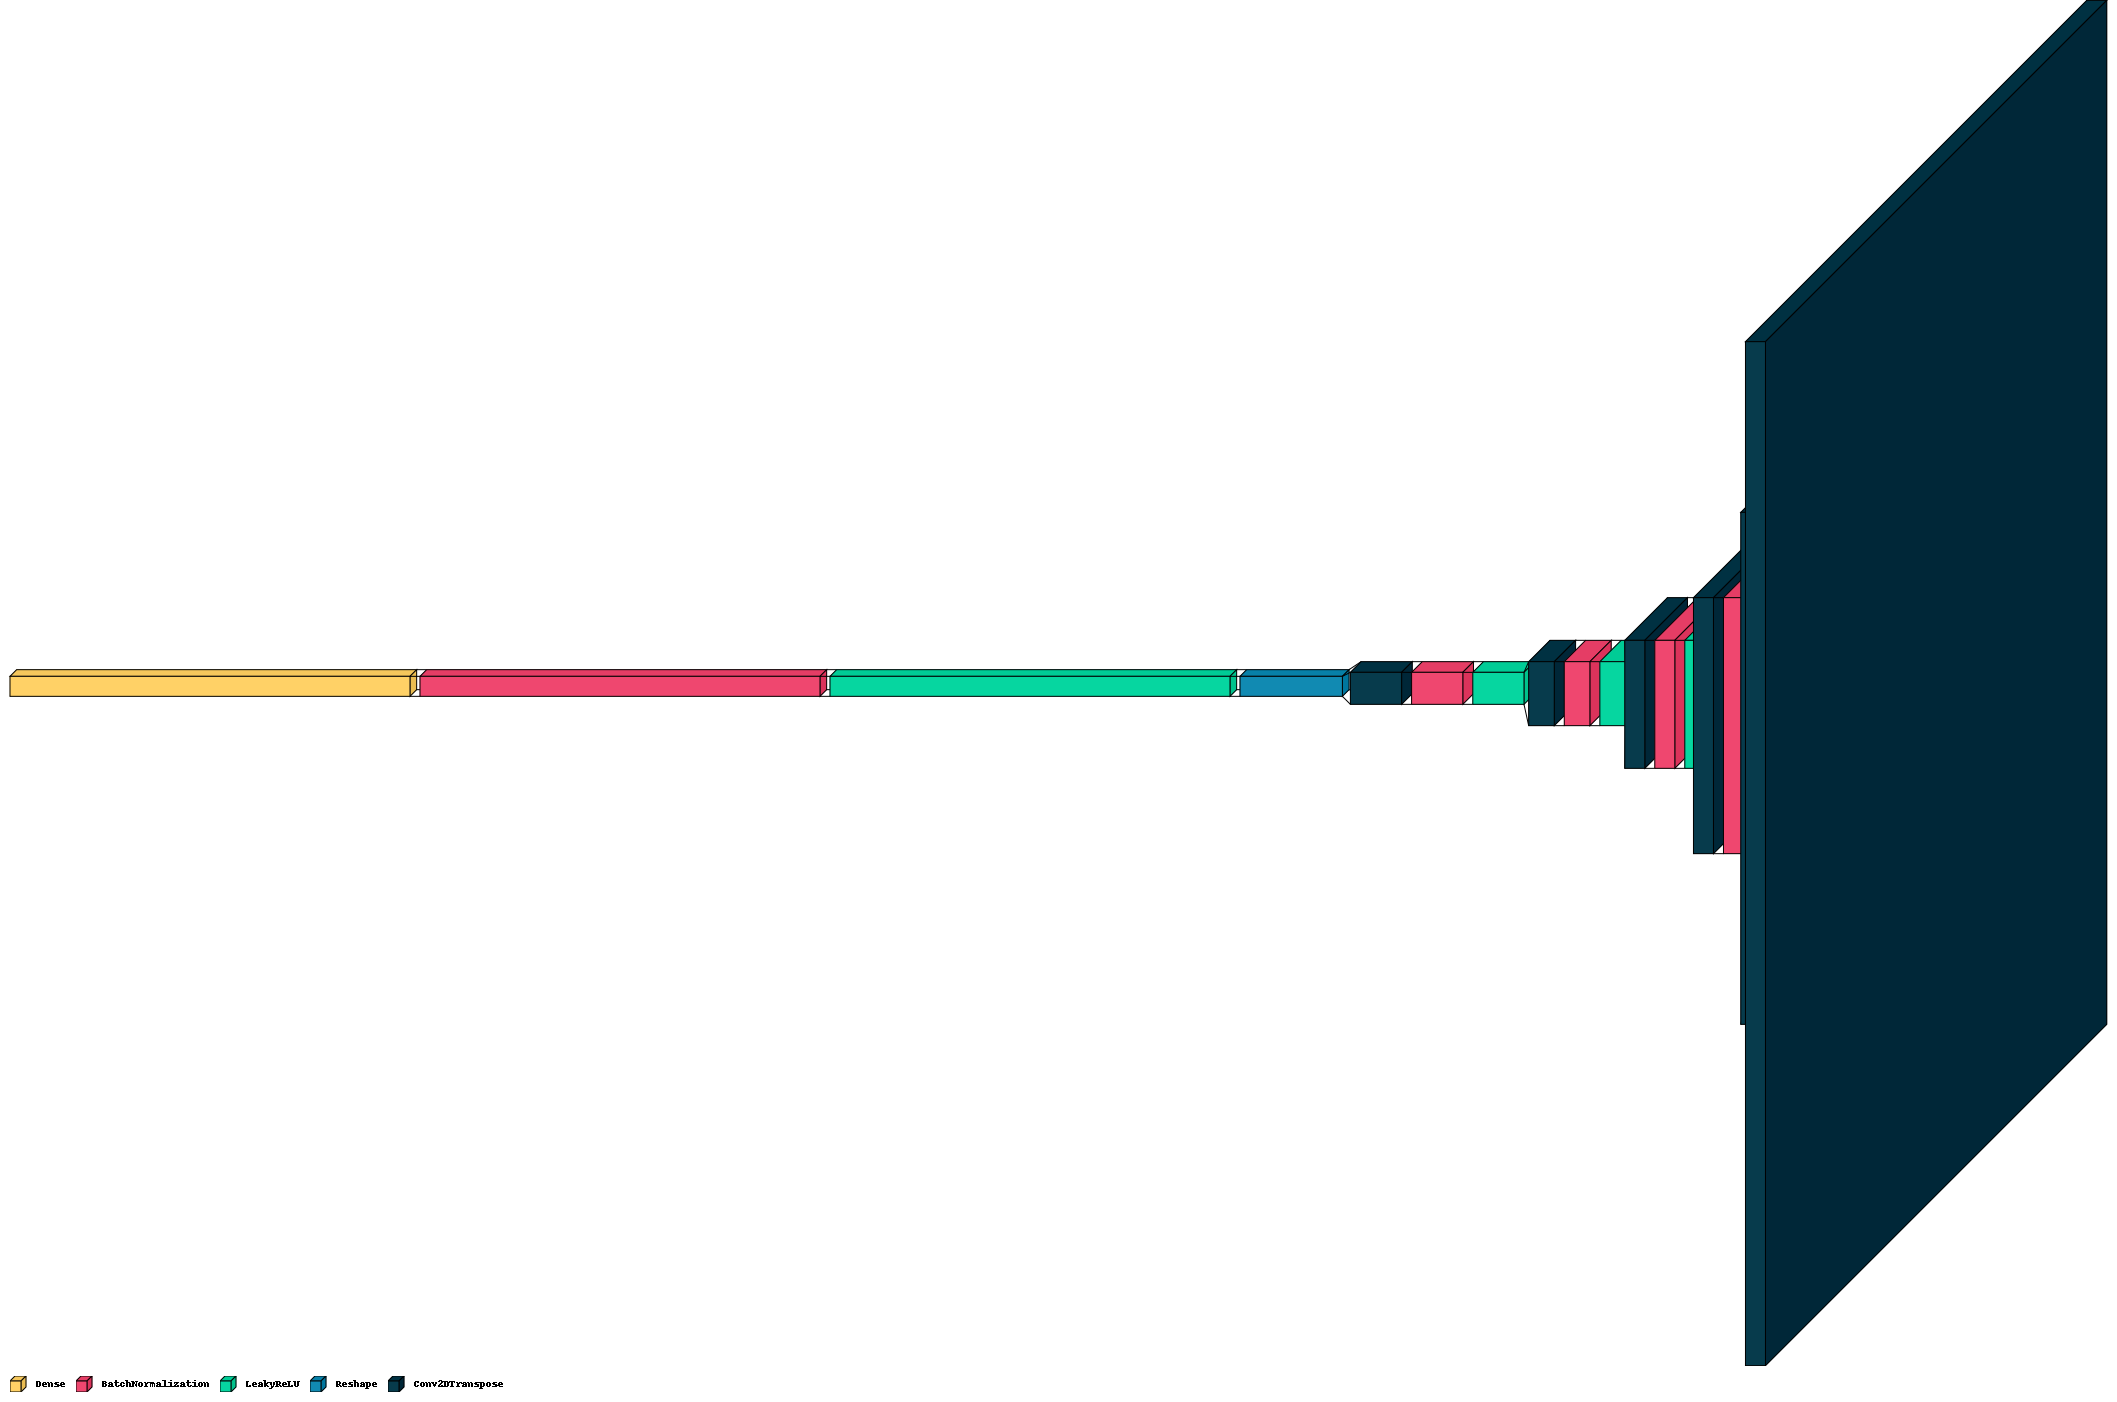

In [14]:
import visualkeras
visualkeras.layered_view(make_generator_model(),legend=True)

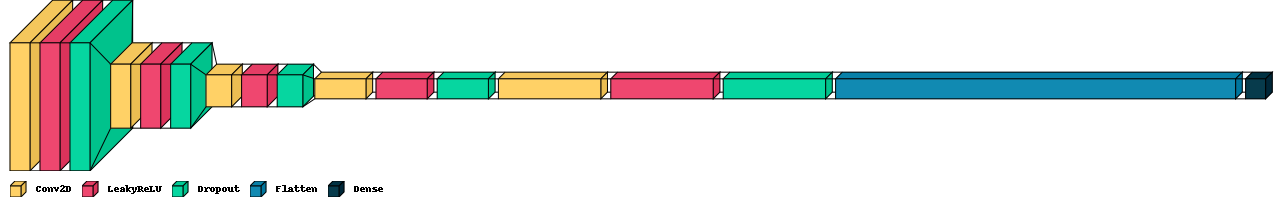

In [10]:
visualkeras.layered_view(make_discriminator_model(), legend=True)